# DS_PROD-1. Подготовка модели к продакшену и деплой

## 1. Введение

Добро пожаловать в раздел, посвящённый моделям машинного обучения в production

Модели машинного обучения сами по себе никому не нужны — они создаются для того, чтобы приносить пользу. В этом и последующих модулях мы разберём, как заставить ML-модель работать на бизнес.

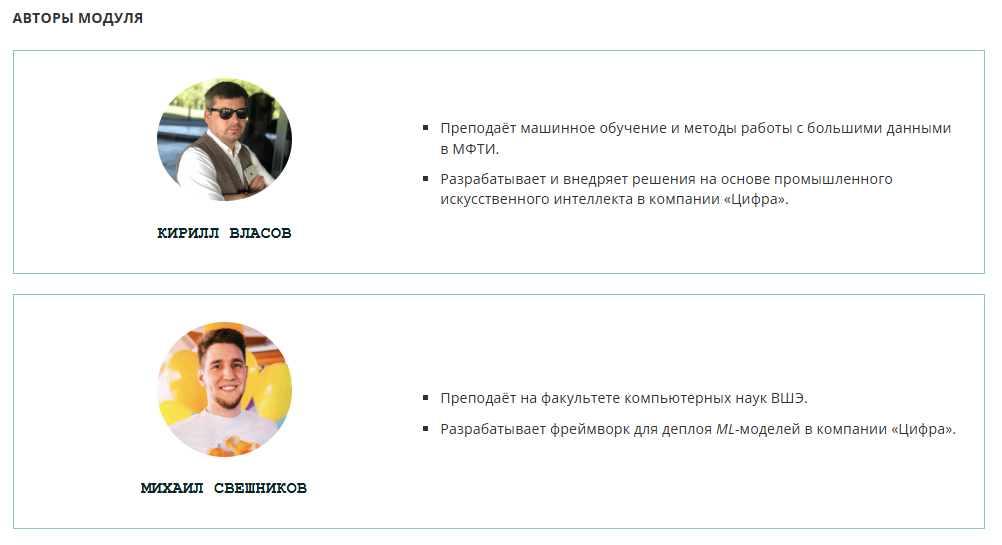

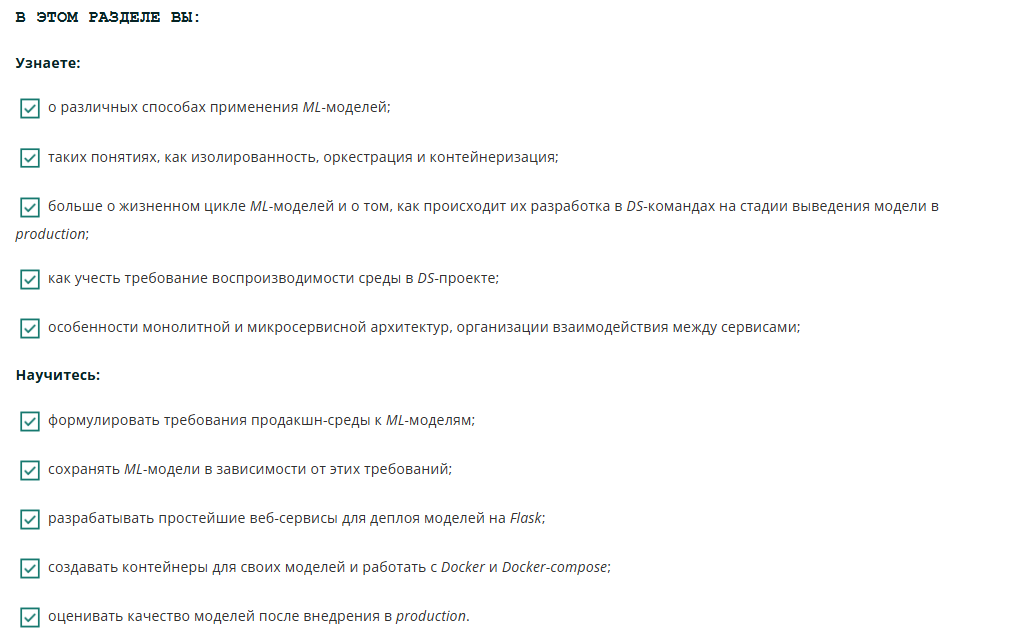

### МОДЕЛИ В ВАКУУМЕ НИКОМУ НЕ НУЖНЫ

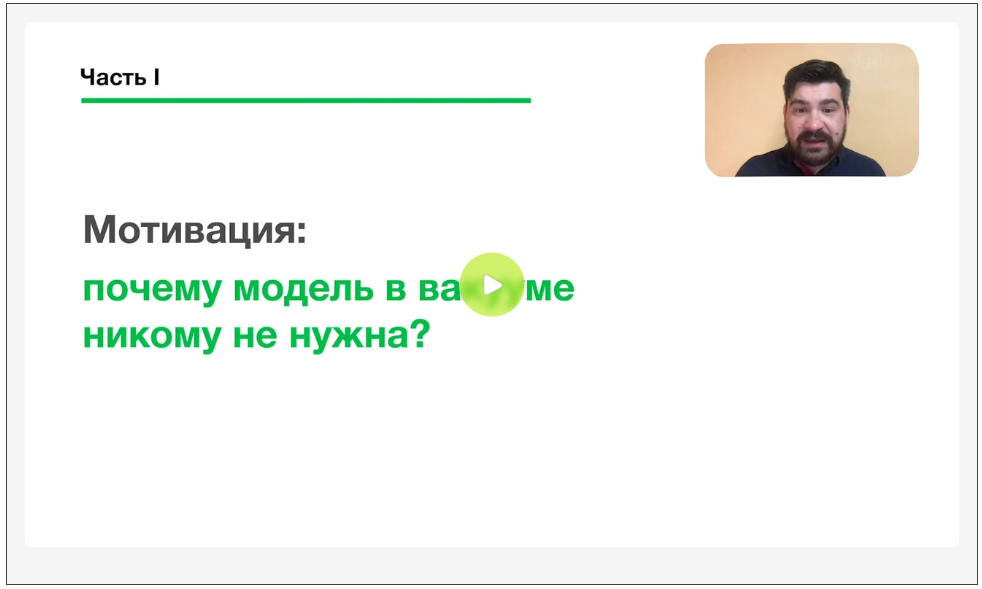

Вы уже умеете создавать модели машинного обучения: они выдают какие-то предсказания, и вы научились оценивать их с помощью метрик качества. Вы можете составлять графики и делать выводы на основе данных. Но что дальше?

Важно задать себе следующие вопросы:

- Какими будут основные потребители результатов? Это будут другие сервисы? Или модель будет встроена в мобильное приложение?
- Как и в каком виде потребители ожидают получать результаты? По времени или по запросу? Если по запросу, то по каким правилам они будут его осуществлять?
- Какая для этого существует (или планируется) инфраструктура?

### ВСПОМИНАЕМ CRISP-DM

Существует множество методологий для управления Data Science-проектами. Наиболее распространённой методологией разработки является знакомая нам модель Cross-Industry Standard Process for Data Mining, или CRISP-DM. Давайте ещё раз взглянем на её этапы:

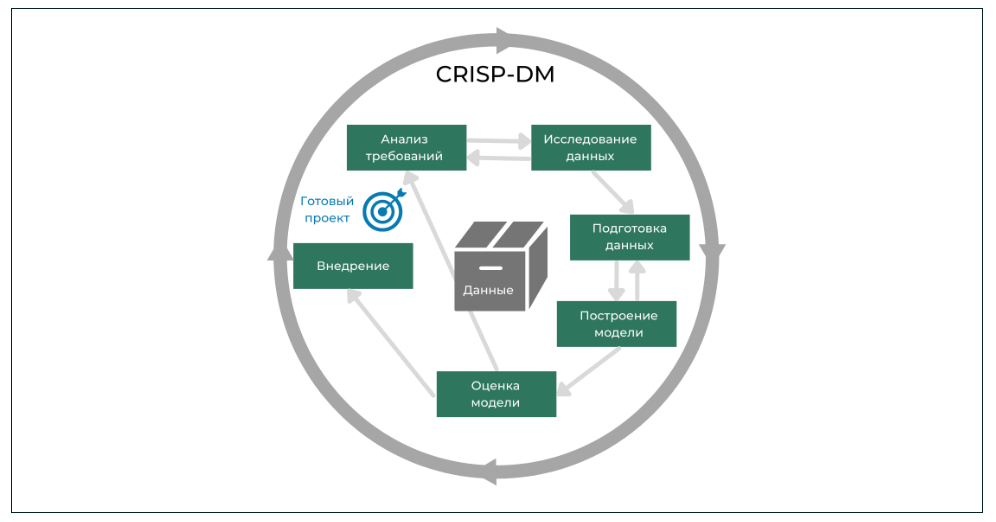

Примечание. Если вы забыли, что из себя представляет методология разработки CRISP-DM, рекомендуем заглянуть в модуль ML-1. «Теория машинного обучения».

На этапе внедрения мы должны понять, будет ли происходить деградация модели во времени в связи с изменением распределений входных данных и возможно ли автоматизировать оценку качества, обновление моделей и их деплой.

Как учесть все эти сложности в процессе разработки моделей? Вот с этим мы и будем разбираться.

### ДЕПЛОЙ МОДЕЛИ

Задача развёртывания приложения на сервере называется деплой (от англ. deployment — внедрение, развёртывание). По сути, это процесс трансформации исходного кода вашего приложения в рабочее состояние на конкретном сервере.

Для того чтобы внедрить модель в продакшн (в минимальном варианте), необходимо:

1. Сохранить обученную модель в файл.
2. Поднять сервер.
3. Доставить и запустить на нём свою модель.

Звучит довольно просто, не так ли?

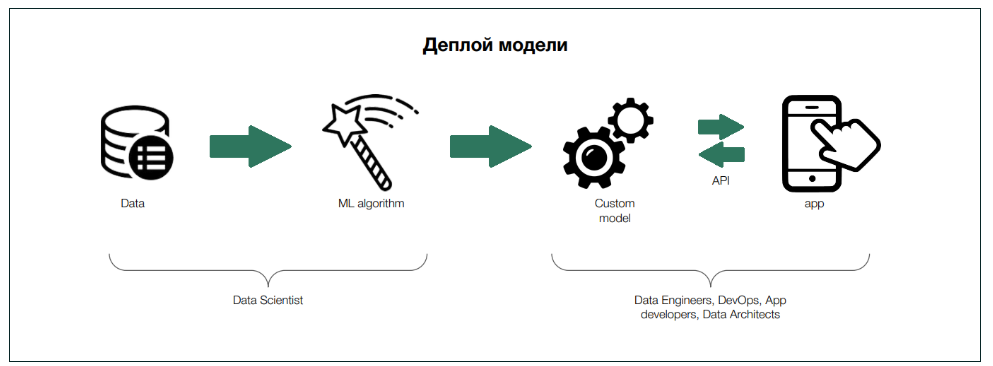

К сожалению, при моделировании зачастую не учитываются вопросы, связанные с деплоем модели и её внедрением в уже существующие системы. Для чего мы обучили модель? Может быть, мы будем использовать её для чат-бота? Может, она должна быть встроена в приложение для iPhone? Как часто потребуется переобучать модель?

Опыт подсказывает, что если модель создаётся «в вакууме», то в итоге её просто нельзя будет вывести в продакшн.

Дополнительной проблемой является то, что большинство библиотек для машинного обучения сфокусированы именно на обучении, а не на предсказании.

Кроме того, в крупных компаниях дата-сайентисты, дата-инженеры, ML-инженеры, занимающиеся внедрением моделей в продакшн, могут быть не просто разными людьми, но и разными командами. На практике может оказаться так, что готовая обученная модель будет внедрена другой командой на другом языке программирования. При этом обычным разработчикам модели машинного обучения могут представляться непрозрачными загадочными чёрными ящиками.

В этом модуле мы будем учиться подготавливать модели к внедрению в продакшн и разворачивать собственный веб-сервис. Как вы увидите дальше, код, который мы написали в Jupyter Notebook, практически никогда не попадает в продакшн без изменений.

**Цели этого модуля:**

- Понять, что такое инференс модели и как организуется сохранение и загрузка модели.
- Узнать, что такое сериализация и десериализация и научиться их различать.
- Понять, что делать, если итоговый проект реализован на другом языке программирования, а ваша модель обучена на Python.
- Рассмотреть вопросы сетевого взаимодействия и узнать о настройке взаимодействия между серверами по сети.
- Закрепить умение писать запросы к серверу (мы затрагивали эту тему в модуле PY-17. «Как получать данные из веб-источников и API», но теперь веб-источник мы будем создавать сами).
- Разобрать основные отличия и области применения фреймворков для разработки веб-сервисов (Django, FastAPI и, конечно, Flask).
- Научиться использовать фреймворк Flask для реализации простейших сервисов моделей.
- Познакомиться с инструментами uWSGI и NGINX, которые помогают повысить пропускную способность и производительность сервера.

# 2. Сохранение и загрузка моделей: pickle и joblib

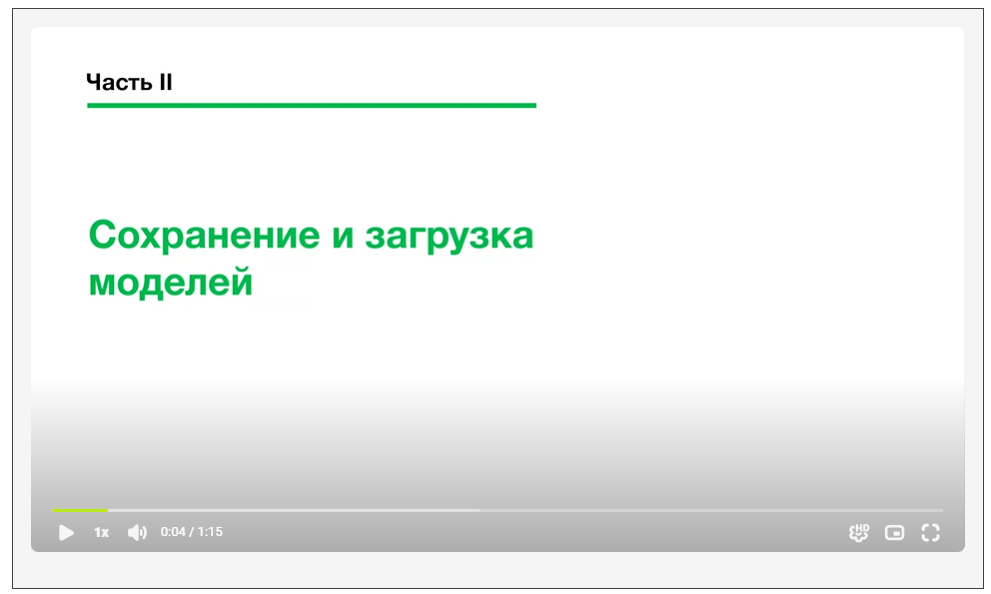

Представьте ситуацию: вы садитесь за руль автомобиля, и… вам нужно заново учиться водить! Сложная ситуация, не правда ли? В реальности мы просто заводим машину, включаем передачу и начинаем движение.

Примерно того же продакшн-среда требует от моделей. И это понятно, ведь намного дешевле с точки зрения расходования ресурсов хранить данные в виде готовой модели, чем каждый раз заново обучать модель на сервере из восьми видеокарт.

Именно поэтому код, который был написан для обучения модели и оценки её качества, крайне редко используется для инференса (от англ inference — вывод). Так называется непрерывная работа алгоритма машинного обучения в конечном приложении. По этой причине при внедрении моделей в продакшн их принято сохранять в готовом виде, то есть уже обученными и готовыми решать реальные задачи.

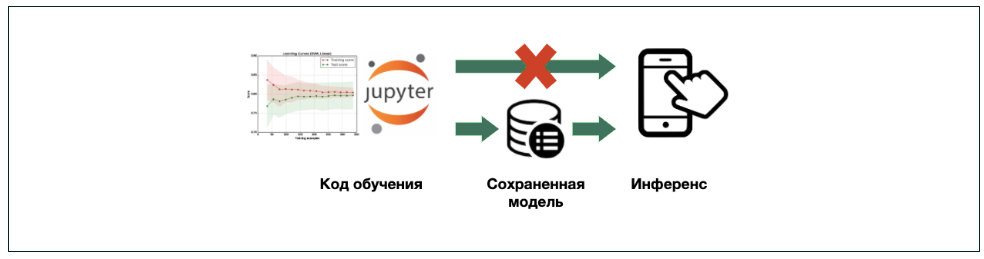

Изучив материалы в этом юните, вы сможете:

1. Подробно разобраться с тем, как с помощью библиотеки pickle сохранять обученные модели машинного обучения, загружать их обратно и заново обращаться к ним для предсказаний.
2. Узнать о способах передачи моделей для внедрения на языках программирования, отличных от Python.
3. Разобраться с темой сериализации.

Совет. Обязательно попробуйте воспроизвести примеры, которые мы будем разбирать далее.

### СЕРИАЛИЗАЦИЯ И ДЕСЕРИАЛИЗАЦИЯ

Как и почти всё в языке программирования Python, обученная модель является объектом. Этот объект не простой, поскольку модель содержит сложную иерархию классов — в каждом классе есть набор полей, ссылающихся на объекты других классов, и так далее.

Например, объект класса RandomForestClassifier из библиотеки sklearn содержит множество полей, часть из которых устанавливается во время инициализации модели (максимальная глубина, количество деревьев в ансамбле, критерий информативности и т. д.), а часть определяется во время обучения модели (последовательность предикатов внутри каждого дерева в ансамбле, значимость признаков). Наша задача — «законсервировать» этот объект (модель), сохранив значение всех полей, которые мы задали при инициализации объекта и получили по итогам обучения. То есть мы должны сохранить модель, включая её внешние и внутренние параметры.

Чтобы гарантировать сохранение всей структуры данных и получить её при загрузке обратно, используется сериализация.

**Сериализация** — это процесс трансформации любой структуры данных, поддерживаемой в языке, в последовательность битов (или байтов). Обратной операцией является **десериализации**.

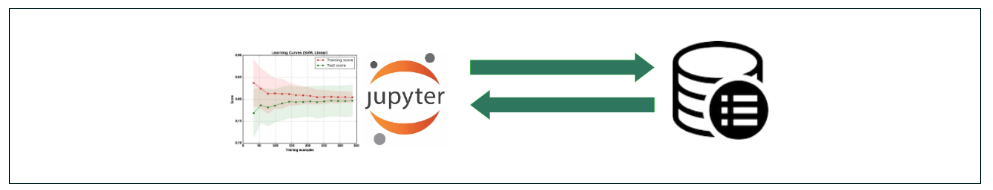

**Зачем это нужно?**

То, в каком виде данные записаны на диск, зачастую может сильно отличаться от того, в каком виде они существуют в памяти программы. И там, и там это будут байты информации, но в файле будет представлена просто их последовательность, а в памяти программы это может быть какой-то объект или даже несколько объектов со структурой.

Приведём простой пример с форматом CSV. Пусть у нас есть файл с одной строкой, где несколько слов записаны через запятую. На диске это будет записано просто как последовательность байтов.

Однако когда мы считываем эту последовательность внутри программы, мы хотим работать с ней как со списком строк, то есть нам нужно не только считать эти данные, но и применить к ним некоторое преобразование:

In [8]:
line = 'word1, word2, word3'

line.split(",")

## ['word1', 'word2', 'word3']

['word1', ' word2', ' word3']

Можно заметить, что после этого преобразования появилось много объектов (каждое слово списка) и некоторая структура (то, как слова расположены в этом списке). Процесс, который мы только что выполнили, называется десериализацией.

Также возможен обратный процесс, когда мы хотим сохранить в виде последовательности байтов какие-то данные из памяти программы. Например, нам нужно снова получить начальную строку:

In [9]:
",".join(['word1', 'word2', 'word3'])

## word1,word2,word3

'word1,word2,word3'

Этот процесс как раз и называется сериализацией.

Мы разобрали простейший пример, но на практике всё гораздо сложнее. Сериализовывать можно не только в текст (как с CSV, JSON и подобными форматами), но и в бинарный формат, который человек не сможет прочитать.

Бывают форматы, которые могут описывать более сложные структуры (тот же JSON). Также можно добавить сжатие итогового набора битов.

Заметим, что программа должна потратить некоторый ресурс CPU, чтобы преобразовать объект в набор байтов и наоборот.

### ИНСТРУМЕНТЫ СЕРИАЛИЗАЦИИ: PICKLE

Посмотрим, с помощью каких средств происходит сериализация объектов в Python.

В стандартную библиотеку Python входит модуль pickle, который служит для сериализации почти всех объектов произвольного типа.

Мы помним, что объекты находятся в оперативной памяти и направляются в байтовые потоки ввода-вывода. В байтовые потоки может быть направлен любой файлоподобный объект.

В ходе десериализации исходный объект воссоздаётся в оперативной памяти с теми же самыми значениями, но с новой идентичностью — новым адресом в памяти.

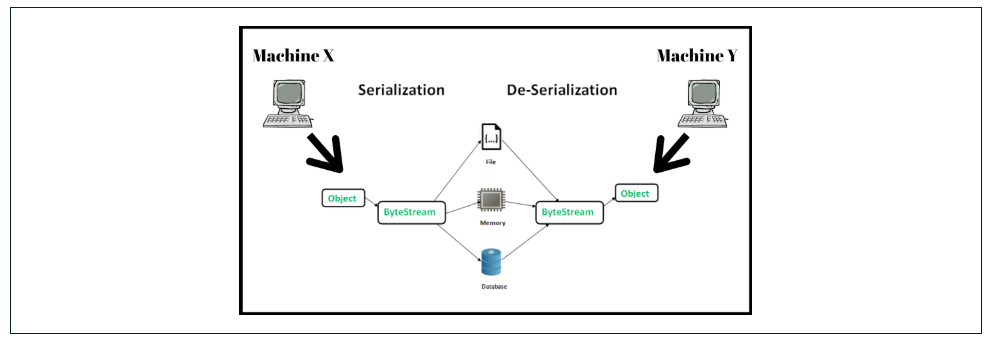

Обратите внимание на предупреждение в официальной документации:

⛔ Warning. The pickle module is not secure. Only unpickle data you trust.

Так как законсервирован может быть абсолютно любой объект, в нём могут быть «спрятаны» различные вредоносные программы или данные. Поэтому будьте внимательны и не проводите десериализацию бинарных файлов, в происхождении которых вы не уверены.

Не переживайте: файлы, предлагаемые для десериализации в рамках нашего курса, безопасны.

Для иллюстрации работы модуля pickle последовательно пройдёмся по всем шагам и разберёмся с тем, как сериализовать уже обученные алгоритмы машинного обучения.

**ШАГ №1**

Обучим модель линейной регрессии на встроенном датасете о диабете — Diabetes dataset.

В данном датасете представлены десять исходных признаков: возраст, пол, индекс массы тела, среднее артериальное давление и шесть измерений сыворотки крови были получены для каждого из 442 пациентов с сахарным диабетом. Интерес представляет количественный показатель прогресса заболевания, замеренный через год после исходного измерения. Тип задачи — регрессия.

Примечание. Для простоты и наглядности мы опустим процесс предобработки данных, разведывательный анализ, разделение выборки на обучающую и тестовую, валидацию модели и подбор гиперпараметров, так как для наших целей это неважно. Мы уверены, что вы уже способны произвести эти этапы самостоятельно.

В качестве модели, прогнозирующей целевую переменную, возьмём простейшую линейную регрессию, и обучим её на исходных данных:

In [10]:
from sklearn.linear_model import LinearRegression

from sklearn.datasets import load_diabetes

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)
# Инициализируем модель линейной регрессии
regressor = LinearRegression()
# Обучаем модель
regressor.fit(X,y)

## LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


В результате выполнения кода получился объект класса LinearRegression, на который ссылается переменная regressor. При этом атрибуты объекта (веса модели линейной регрессии) были сформированы во время обучения. То есть объект regressor теперь является обученной моделью.

**ШАГ №2**

Далее, когда мы получили обученную модель, нам необходимо сериализовать её, превратив объект Python в поток байтов. Для этого импортируем модуль pickle и воспользуемся функцией dumps(), в которую нужно передать объект Python.

In [11]:
import pickle

# Производим сериализацию обученной модели
model = pickle.dumps(regressor)

print(type(model))
print(type(regressor))
## bytes
## sklearn.linear_model._base.LinearRegression

<class 'bytes'>
<class 'sklearn.linear_model._base.LinearRegression'>


Как видим, мы создали объект model типа bytes.

**ШАГ №3**

Давайте попробуем восстановить (десериализовать) объект Python. Для этого в модуле pickle есть функция loads(), в которую нужно передать сериализованный объект (поток байтов).

In [12]:
# Производим десериализацию
regressor_from_bytes = pickle.loads(model)
regressor_from_bytes
## LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


В результате десериализации мы смогли восстановить исходный объект (модель).

**ШАГ №4**

Сохраним сериализованный объект прямо в файл. Для этого в pickle есть функция dump() (без s на конце). В неё необходимо передать имя файла или ссылку на открытый файл. Файл назовём myfile, его расширение — .pkl (формат данных pickle):

In [13]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('myfile.pkl', 'wb') as output:
    pickle.dump(regressor, output)

Теперь у нас есть бинарный файл с готовой моделью, и мы можем передать его, например, ML-инженерам, которые будут заниматься деплоем модели на сервер.

**ШАГ №5**

Посмотрим на код, который восстанавливает (десериализует) обученную модель из файла myfile.pkl. Для этого в pickle есть функция load() (без s на конце). В неё необходимо передать имя файла или ссылку на открытый файл.

In [14]:
# Производим десериализацию и извлекаем модель из файла формата pkl
with open('myfile.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

regressor_from_file
## LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


**ШАГ №6**

Убедимся, что методы и результаты предсказаний обученной модели и модели, загруженной из файла, совпадают:

In [15]:
# Проверяем, что все элементы массивов предсказаний совпадают между собой
all(regressor.predict(X) == regressor_from_bytes.predict(X))
## True
all(regressor.predict(X) == regressor_from_file.predict(X))
## True

True

Как видите, исходная и восстановленная из байтов и файла модели дают одинаковые предсказания. Это значит, что теперь мы можем импортировать наши обученные модели в любое Python-приложение и пользоваться ими, минуя этап обучения и все этапы, предшествующие ему.

### ОГРАНИЧЕНИЯ

Как мы упоминали, у pickle есть ограничения. Например, мы не можем сериализовать лямбда-функции. Давайте посмотрим, что нам вернёт следующий код:

In [16]:
my_lambda = lambda x: x*2
with open('my_lambda.pkl', 'wb') as output:
    pickle.dump(my_lambda, output)
 
##"PicklingError: Can't pickle <function <lambda>"

PicklingError: Can't pickle <function <lambda> at 0x00000239E5F904C0>: attribute lookup <lambda> on __main__ failed

Совет. В таких случаях лучше пользоваться пакетом dill.

https://github.com/uqfoundation/dill

### СОХРАНЕНИЕ ПАЙПЛАЙНА

Ранее мы посмотрели простейший пример сериализации готовой модели.

У вас мог возникнуть вопрос: что делать, если перед подачей данных в модель их необходимо предобработать, например произвести стандартизацию, исключить неинформативные признаки? Неужели придётся прописывать все эти шаги в коде инференса модели? А что если вопросами инференса занимаются совершенно другие специалисты, которые вообще ничего не знают о машинном обучении и не умеют производить предобработку данных?

Конечно, мы должны передать результаты в таком виде, чтобы ими можно было воспользоваться без лишних манипуляций.

Мы уже упоминали, что pickle работает с любыми объектами Python. Поэтому для сохранения может быть доступна не просто обученная модель, но и целый пайплайн, включающий предобработку данных.

Примечание. Если вы забыли, что такое пайплайны и как их формировать с помощью библиотеки sklearn, рекомендуем заглянуть в модуль ML-8. «Продвинутые методы машинного обучения».

Например, мы хотим сериализовать пайплайн, который включает в себя min-max-нормализацию и отбор пяти наиболее важных факторов на основе корреляции Пирсона. Полученные в результате данные отправляются на вход модели линейной регрессии.

In [17]:
import pickle

from sklearn.linear_model import LinearRegression

from sklearn.datasets import load_diabetes

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)

# Создаём пайплайн, который включает нормализацию, отбор признаков и обучение модели
pipe = Pipeline([  
  ('Scaling', MinMaxScaler()),
  ('FeatureSelection', SelectKBest(f_regression, k=5)),
  ('Linear', LinearRegression())
  ])

# Обучаем пайплайн
pipe.fit(X, y)

,steps,"[('Scaling', ...), ('FeatureSelection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,score_func,<function f_r...00239BBF50940>
,k,5
,fit_intercept,True
,copy_X,True


Пайплайн обучен. Давайте сохраним его в файл с помощью pickle:

In [18]:
# Сериализуем pipeline и записываем результат в файл
with open('my_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Если сериализация завершилась успешно, то при инференсе модели мы сможем восстановить её из файла:

In [19]:
# Десериализуем pipeline из файла
with open('my_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

Проверим, что результаты исходного и десериализованного пайплайнов и идентичны:

In [20]:
# Сравниваем предсказания исходного и восстановленного пайплайнов
print(all(pipe.predict(X) == loaded_pipe.predict(X)))

## True

True


Примечание. Если мы хотим сохранять сериализованные пайплайны в виде потока байтов, нужно использовать функции dumps() и loads(), а не dump() и load().

Однако в процессе предобработки могут возникнуть шаги, которые нельзя реализовать стандартными методами sklearn. Например, для решения многих задач в нашем курсе мы часто использовали feature engineering, чтобы повысить качество работы моделей. Как встроить этот шаг в исходный пайплайн?

Для этого в sklearn можно организовать так называемые **кастомные трансформеры**. Такой трансформер должен наследоваться от двух классов: TransformerMixin и BaseEstimator.

Посмотрим на шаблон кастомного трансформера:

In [21]:
from sklearn.base import TransformerMixin, BaseEstimator
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''
 
    def __init__(self):
        '''
        Здесь прописывается инициализация параметров, не зависящих от данных.
        '''
        pass
 
    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''

        return self
 
    def transform(self, X):
        '''
        Здесь прописываются действия с данными.
        '''
        return X

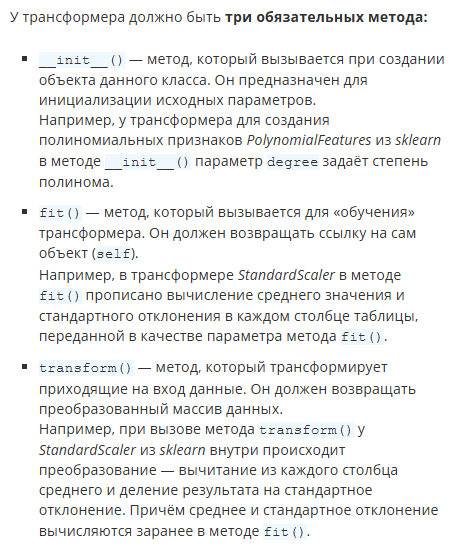

Примечание. Как мы знаем, у некоторых трансформеров из sklearn, например у того же MinMaxScaler, есть ещё и метод fit_transform(), который является комбинацией методов fit() и transform().

Наш трансформер пока что ничего не делает. Предположим, мы хотим генерировать в данных новый признак, который является простым произведением первых трёх столбцов таблицы. Давайте пропишем в методе transform() эти действия.

Для работы такого трансформера нужны только исходные данные без дополнительных параметров, поэтому методы __init__() и fit() остаются без изменений.

In [24]:
import numpy as np
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''


    def __init__(self):
        '''Здесь прописывается инициализация параметров, не зависящих от данных.'''
        pass


    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''
        return self


    def transform(self, X):
        '''Здесь прописываются действия с данными.'''
        # Создаём новый столбец как произведение первых трёх
        new_column = X[:, 0] * X[:, 1] * X[:, 2]
        # Для добавления столбца в массив нужно изменить его размер на (n_rows, 1)
        new_column = new_column.reshape(X.shape[0], 1)
        # Добавляем столбец в матрицу измерений
        X = np.append(X, new_column, axis=1)
        return X

Посмотрим, как работает наш кастомный трансформер. Создадим объект трансформера, вызовем метод transform и посмотрим на результирующий размер таблицы.

In [25]:
# Инициализируем объект класса MyTransformer (вызывается метод __init__)
custom_transformer = MyTransformer()
# Чисто формально вызываем метод fit, но у нас он ничего не делает
custom_transformer.fit(X)
# Трансформируем исходные данные (вызывается метод transform)
X_transformed = custom_transformer.transform(X)
print('Shape before transform: {}'.format(X.shape))
print('Shape after transform: {}'.format(X_transformed.shape))

## Shape before transform: (442, 10)
## Shape after transform: (442, 11)

Shape before transform: (442, 10)
Shape after transform: (442, 11)


Видно, что в результате трансформации в исходную матрицу наблюдений добавился новый столбец.

Теперь давайте встроим этот трансформер в сам пайплайн — для этого достаточно добавить новый шаг в пайплайн.

In [26]:
# Создаём пайплайн, который включает Feature Engineering, нормализацию, отбор признаков и обучение модели
pipe = Pipeline([  
  ('FeatureEngineering', MyTransformer()),
  ('Scaling', MinMaxScaler()),
  ('FeatureSelection', SelectKBest(f_regression, k=5)),
  ('Linear', LinearRegression())
  ])

# Обучаем пайплайн
pipe.fit(X, y)

,steps,"[('FeatureEngineering', ...), ('Scaling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,score_func,<function f_r...00239BBF50940>
,k,5
,fit_intercept,True
,copy_X,True


Наконец можно сериализовать полученный pipeline:

In [27]:
# Сериализуем pipeline и записываем результат в файл
with open('my_new_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Теперь мы можем передать пайплайн и воспользоваться им для инференса, предварительно произведя десериализацию.

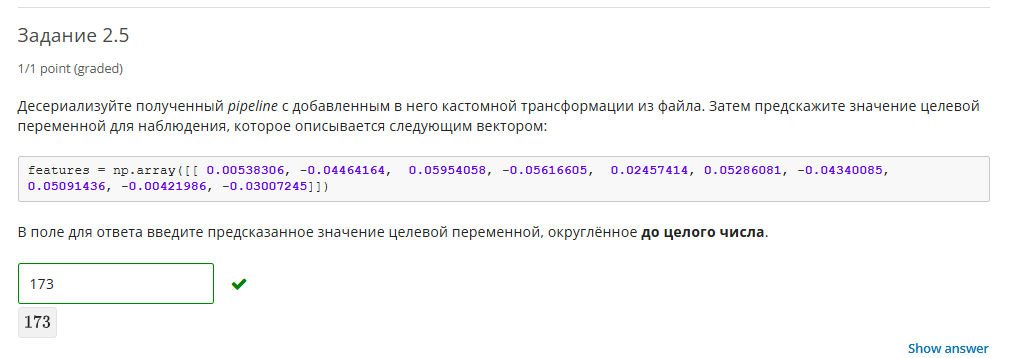

In [28]:
# Десериализуем pipeline из файла
with open('my_new_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file) 
    
features =np.array([[ 0.00538306, -0.04464164,  0.05954058, -0.05616605,  0.02457414, 0.05286081, -0.04340085,  0.05091436, -0.00421986, -0.03007245]])
 
# Формируем предсказание
print(np.round(loaded_pipe.predict(features)))

[173.]


В дополнение предлагаем вам ознакомиться с примерами использования пайплайнов (на англ. языке):

- Sklearn Pipeline Tutorial; https://www.kaggle.com/code/sermakarevich/sklearn-pipelines-tutorial
- Pipeline Guide (GitHub); https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c
- A Simple Guide to Scikit-learn Pipelines.https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

### БИБЛИОТЕКА JOBLIB

Как мы видим, pickle прекрасно справляется со своей задачей: мы можем сериализовать и восстанавливать любые Python-объекты, включая модели и даже пайплайны. Однако иногда массивы данных, на которых обучаются модели, бывают настолько большими, что после загрузки из pickle невозможно восстановить объект полностью.

В таких случаях вместо pickle лучше использовать библиотеку joblib. Этот модуль более эффективен и надёжен для работы с объектами, которые содержат большие массивы данных. Пожалуй, единственный минус этого модуля в том, что он может «консервировать» только в файл, поэтому вы не сможете получить объект в виде бинарной строки и работать с ним. В модуле попросту отсутствуют методы для работы с бинарной строкой. Формат файлов для сохранения — .joblib.

В остальном работа с joblib полностью идентична работе с pickle: после обучения модели производим сериализацию с помощью функции dump(), а в коде самого приложения, где нужно использовать модель, выполняем десериализацию с помощью функции load(). В каждую из этих функций необходимо передать путь до файла для записи и чтения соответственно.

Для иллюстрации работы сохраним полученную линейную регрессию:

In [29]:
import joblib

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)
# Обучаем модель линейной регрессии
regressor = LinearRegression()
regressor.fit(X, y)
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(regressor, 'regr.joblib')

## ['regr.joblib']

['regr.joblib']

Загрузим файл заново (загрузка может быть произведена в другом файле с кодом):

In [30]:
# Десериализуем модель из файла
clf_from_jobliv = joblib.load('regr.joblib') 
# Сравниваем предсказания
all(regressor.predict(X) == clf_from_jobliv.predict(X))

## True

True

# 3. Практика: pickle

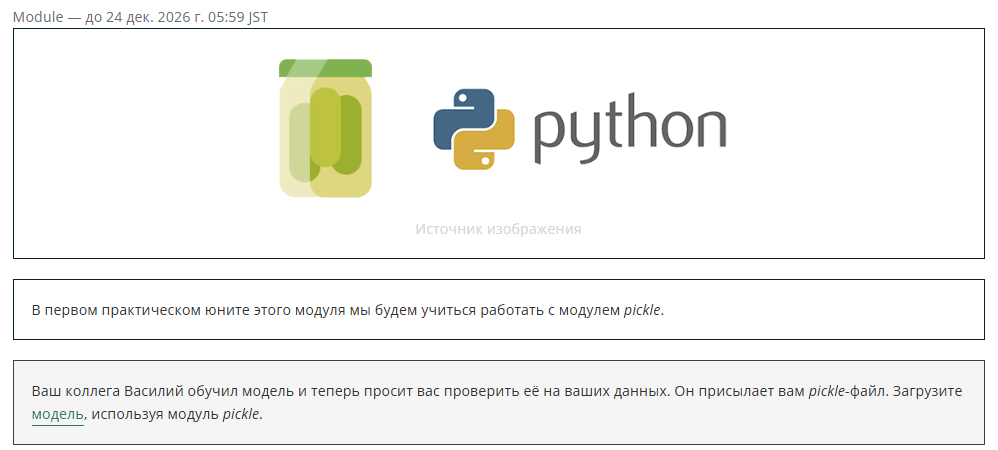

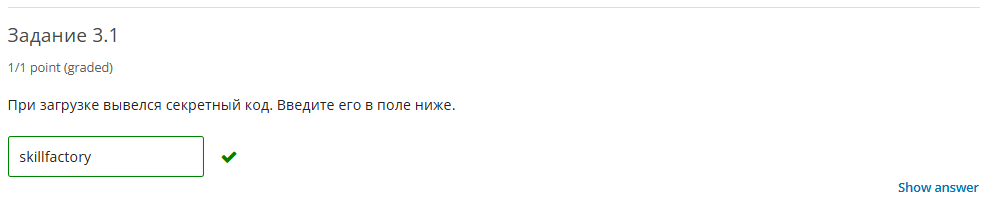

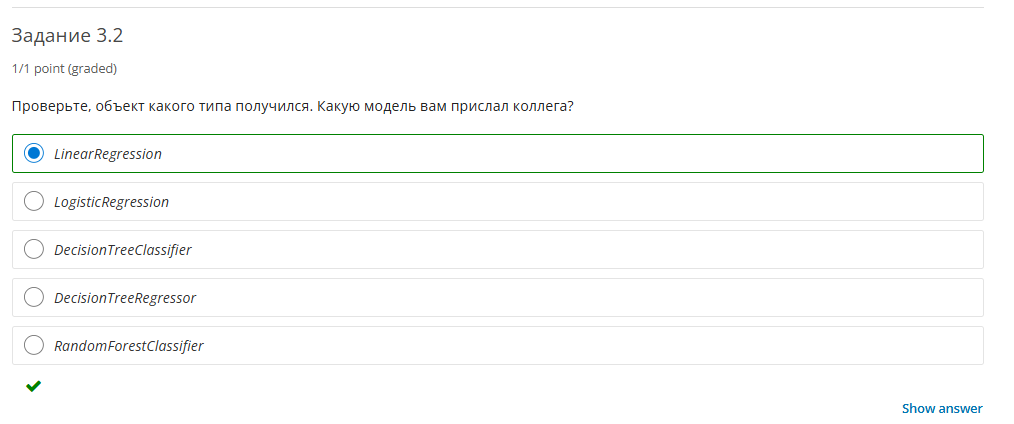

In [31]:
import pickle
 
with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

secret word: skillfactory
how is this possible? answer is here: https://youtu.be/xm-A-h9QkXg


C:\Users\tgorbunov\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


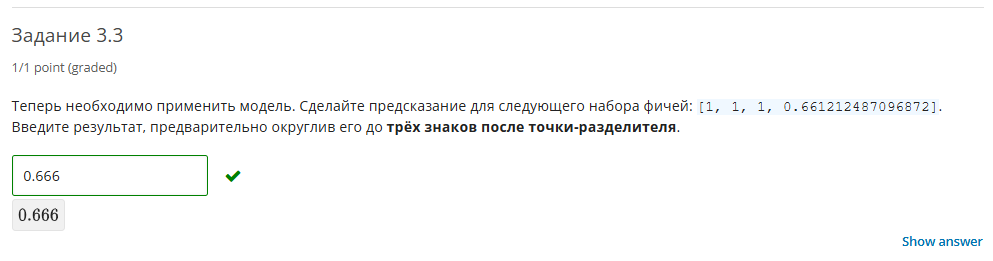

In [32]:
print(model.predict([[1, 1, 1, 0.661212487096872]]))

[0.666]


У присланной вам модели есть два поля (атрибута) с именами a и b. Создайте из них словарь с такими же именами ключей и значениями, а затем сохраните его в файл с помощью модуля pickle.

Чтобы вы могли проверить правильность решения задания, мы создали специальный проверочный скрипт. Скачайте его здесь.

Сохраните его рядом с вашим pickle-файлом (в той же папке) и запустите, передав первым аргументом имя файла. Если вы всё сделали правильно, на экран выведется ответ для следующего задания.

Как запустить скрипт?

В ячейке Jupyter Notebook:

In [35]:
!python hw1_check_ol.py имя_pickle_файла.pkl

Traceback (most recent call last):
  File "c:\Users\tgorbunov\OneDrive - SLB\Desktop\Skillfactory\Python_project folder_TG\IDE\Skillfactory\Production Release\hw1_check_ol.py", line 1, in <module>
    (lambda __g, __print: [[[[[[(lambda __after: [[(f.close(), [(lambda __after: (__print('wrong answer'), __after())[1] if (((14 * a) + b) != ((14 * asd()) + ____asd())) else [(__print(('secret code 2:', h.hexdigest()[:5])), __after())[1] for __g['h'] in [(hashlib.md5((____asd.__name__ + asd.__name__).encode()))]][0])(lambda: __after()) for (__g['a'], __g['b']) in [((load['a'], load['b']))]][0])[1] for __g['load'] in [(pickle.load(f))]][0] for __g['f'] in [(open(sys.argv[1], 'rb'))]][0] if (__name__ == '__main__') else __after())(lambda: None) for __g['asd'], asd.__name__ in [(lambda : (____asd() - 8), 'asd')]][0] for __g['____asd'], ____asd.__name__ in [(lambda : ((int(math.pi) * 4) + 1), '____asd')]][0] for __g['hashlib'] in [(__import__('hashlib', __g, __g))]][0] for __g['sys'] in [(__imp

В терминале:

In [ ]:
cd имя_папки_со_скриптом

python hw1_check_ol.py имя_pickle_файла.pkl

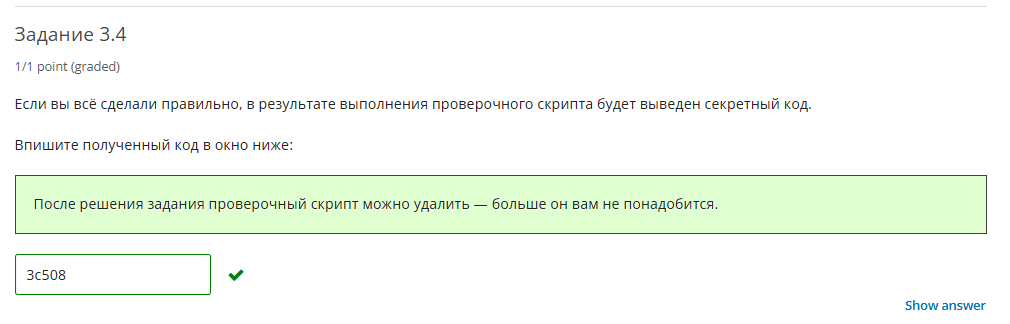

In [37]:
my_dict = {'a': model.a, 'b': model.b}

with open('my_dict.pkl', 'wb') as pkl_file:
    pickle.dump(my_dict, pkl_file)

!python hw1_check_ol.py my_dict.pkl

('secret code 2:', '3c508')


# 4. Сохранение и загрузка моделей: PMML и ONNX-ML